In [1]:
import tensorflow as tf
from tensorflow import keras

5
(11, 11, 3, 4)
(2, 427, 640, 4)


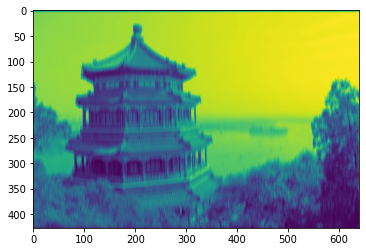

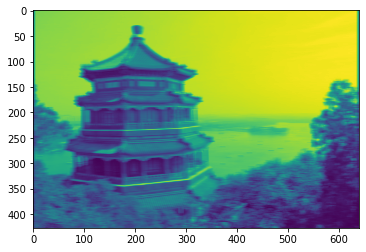

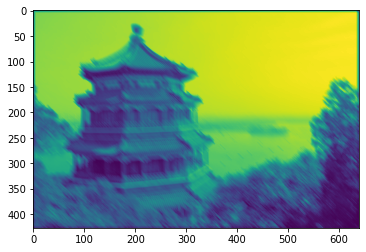

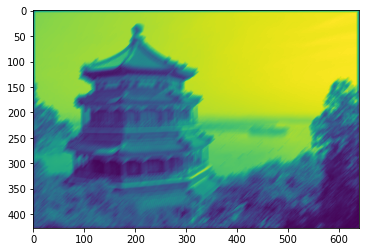

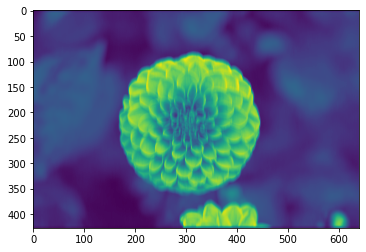

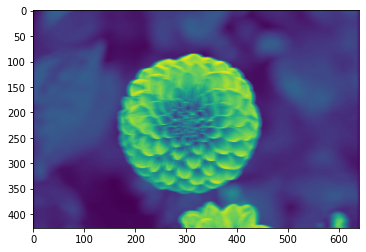

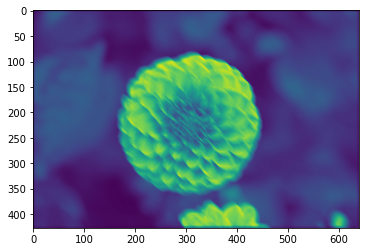

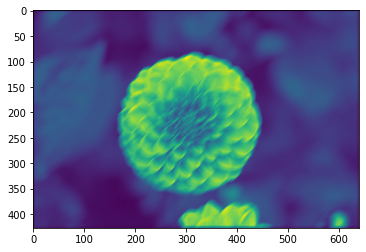

In [2]:
from sklearn.datasets import load_sample_image
import numpy as np
import matplotlib.pyplot as plt

china, flower = load_sample_image('china.jpg'), load_sample_image('flower.jpg')
china, flower = china / 255.0, flower / 255.0

images = np.array([china, flower])
batch_size, height, width, channels = images.shape
kernel_shape = (11, 11)
print(kernel_shape[0] // 2)

filters = np.zeros(shape=(*kernel_shape, channels, 4), dtype=np.float32)
filters[:, kernel_shape[1] // 2, :, 0] = 10.0 # vertical line of ones
filters[kernel_shape[0] // 2, :, :, 1] = 10.0 # horizontal line of ones

# diagonal filter creation
for i in range(kernel_shape[0]):
  filters[i, i, :, 2] = 10.0

for i in range(kernel_shape[0]):
  filters[kernel_shape[0] - 1 - i, i, :, 3] = 10.0

print(filters.shape)

outputs = tf.nn.conv2d(images, filters, strides=1, padding='SAME')
print(outputs.shape)

plt.imshow(outputs[0, :, :, 0])
plt.show()
plt.imshow(outputs[0, :, :, 1])
plt.show()
plt.imshow(outputs[0, :, :, 2])
plt.show()
plt.imshow(outputs[0, :, :, 3])
plt.show()

plt.imshow(outputs[1, :, :, 0])
plt.show()
plt.imshow(outputs[1, :, :, 1])
plt.show()
plt.imshow(outputs[1, :, :, 2])
plt.show()
plt.imshow(outputs[1, :, :, 3])
plt.show()

In [3]:
import tensorflow_datasets as tfds

train, val, test =  tfds.load('fashion_mnist', batch_size=128, split=['train[20%:]', 'train[:20%]', 'test'], as_supervised=True)
train, val, test = train.shuffle(len(train)).prefetch(10), test.prefetch(10), test.prefetch(10)
print(len(train), len(val), len(test))

375 79 79


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
for item in train.take(1):
  # print(item[0])
  print(tf.scalar_mul(0.00390625, item[0]))

Num GPUs Available:  0


2022-12-03 13:57:48.567858: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


TypeError: Cannot convert 0.00390625 to EagerTensor of dtype uint8

In [5]:
model = keras.models.Sequential([
  keras.layers.Input(shape=(28, 28, 1)),
  keras.layers.Lambda(lambda x: tf.scalar_mul(0.00390625, x)),
  keras.layers.Conv2D(64, 7, padding='same', activation='relu'),
  keras.layers.MaxPool2D(2),
  keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
  keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
  keras.layers.MaxPool2D(2),
  keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
  keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
  keras.layers.MaxPool2D(2),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(64, activation='relu'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(10, activation='softmax'),
])

model.compile(
  loss=keras.losses.sparse_categorical_crossentropy,
  metrics=[keras.metrics.sparse_categorical_accuracy],
  # optimizer=keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True),
  optimizer=keras.optimizers.Nadam(0.0035),
)

model.fit(train.shuffle(len(train)).prefetch(10), validation_data=val, epochs=256, callbacks=[
  keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
  keras.callbacks.ReduceLROnPlateau(factor=0.5,patience=5),
])

Epoch 1/256
 65/375 [====>.........................] - ETA: 1:20 - loss: 2.3574 - sparse_categorical_accuracy: 0.1252

KeyboardInterrupt: 

In [132]:
pred = model.predict(test)
pred = tf.argmax(pred, axis=1)
labels = tf.convert_to_tensor([y[1] for y in test.unbatch()])
print(tf.math.confusion_matrix(labels, pred))
sum = 0
total = len(pred)
for i in range(len(pred)):
  if pred[i] == labels[i]:
    sum += 1
print(sum, total, sum / total)

79/79 [==============================] - 5s 66ms/step
tf.Tensor(
[[871   1  15  18   3   2  82   0   8   0]
 [  1 983   0  11   1   0   2   0   2   0]
 [ 16   1 883   5  46   0  48   0   1   0]
 [ 23   6   8 913  29   0  18   0   1   2]
 [  5   0  93  23 821   0  58   0   0   0]
 [  0   0   0   0   0 973   0  17   1   9]
 [132   1  86  23  63   0 685   0  10   0]
 [  0   0   0   0   0   9   0 976   0  15]
 [  2   1   0   1   1   3   2   1 988   1]
 [  0   0   0   0   0   6   0  27   1 966]], shape=(10, 10), dtype=int32)
9059 10000 0.9059


In [135]:
# residual unit layer
class ResidualUnit(keras.layers.Layer):
  def __init__(self, filters, strides=1, activation='relu', **kwargs):
    super().__init__(**kwargs)
    self.strides = strides
    self.activation = keras.activations.get(activation)
    self.main_layers = [
      keras.layers.Conv2D(filters, 3, strides=strides, padding='same', use_bias=False),
      keras.layers.BatchNormalization(),
      self.activation,
      keras.layers.Conv2D(filters, 3, strides=1, padding='same', use_bias=False),
      keras.layers.BatchNormalization(),
    ]
    self.skip_layers = []
    if strides > 1:
      self.skip_layers = [
        keras.layers.Conv2D(filters, 1, strides=strides, padding='same', use_bias=False),
        keras.layers.BatchNormalization(),
      ]
  
  def call(self, inputs):
    Z = inputs
    for layer in self.main_layers:
      Z = layer(Z)
    skip_Z = inputs
    for layer in self.skip_layers:
      skip_Z = layer(skip_Z)
    return self.activation(Z + skip_Z)
  
# resnet-34 architecture
model = keras.models.Sequential()
# default resnet shape is 224, 224, 3 but for fashion mnist I changed it
model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=(28, 28, 1), padding='same', use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same'))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
  strides = 1 if filters == prev_filters else 2
  model.add(ResidualUnit(filters, strides=strides))
  prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation='softmax'))

In [ ]:
model.compile(
  loss=keras.losses.sparse_categorical_crossentropy,
  metrics=[keras.metrics.sparse_categorical_accuracy],
  optimizer=keras.optimizers.SGD(learning_rate=0.0035, momentum=0.9, nesterov=True),
  # optimizer=keras.optimizers.Nadam(0.0035),
)

In [138]:
model.fit(train.shuffle(len(train)).prefetch(10), validation_data=val, epochs=32, callbacks=[
  keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
  keras.callbacks.ReduceLROnPlateau(factor=0.5,patience=5),
])

Epoch 1/32
375/375 [==============================] - 410s 1s/step - loss: 0.4866 - sparse_categorical_accuracy: 0.8220 - val_loss: 0.4989 - val_sparse_categorical_accuracy: 0.8111 - lr: 0.0035
Epoch 2/32
375/375 [==============================] - 402s 1s/step - loss: 0.3186 - sparse_categorical_accuracy: 0.8845 - val_loss: 0.3579 - val_sparse_categorical_accuracy: 0.8695 - lr: 0.0035
Epoch 3/32
375/375 [==============================] - 391s 1s/step - loss: 0.2671 - sparse_categorical_accuracy: 0.9024 - val_loss: 0.3367 - val_sparse_categorical_accuracy: 0.8803 - lr: 0.0035
Epoch 4/32
375/375 [==============================] - 402s 1s/step - loss: 0.2326 - sparse_categorical_accuracy: 0.9136 - val_loss: 0.3112 - val_sparse_categorical_accuracy: 0.8885 - lr: 0.0035
Epoch 5/32
164/375 [============>.................] - ETA: 3:35 - loss: 0.2009 - sparse_categorical_accuracy: 0.9270

KeyboardInterrupt: 

In [139]:
pred = model.predict(test)
pred = tf.argmax(pred, axis=1)
labels = tf.convert_to_tensor([y[1] for y in test.unbatch()])
print(tf.math.confusion_matrix(labels, pred))
sum = 0
total = len(pred)
for i in range(len(pred)):
  if pred[i] == labels[i]:
    sum += 1
print(sum, total, sum / total)

79/79 [==============================] - 6s 67ms/step
tf.Tensor(
[[767   0  23  41   3   1 160   0   5   0]
 [  0 987   0   8   2   0   3   0   0   0]
 [ 16   1 911  12  39   0  21   0   0   0]
 [ 14  32   9 894  28   0  20   0   3   0]
 [  2   1 163  35 780   0  18   0   1   0]
 [  0   0   0   0   0 979   0  14   2   5]
 [ 88   5 137  34 171   0 553   0  12   0]
 [  0   0   0   0   0  22   0 939   1  38]
 [  1   1   2   3   4   2   4   4 979   0]
 [  0   0   1   0   0   4   0  27   1 967]], shape=(10, 10), dtype=int32)
8756 10000 0.8756


In [177]:
# reusing pretrained models lower layers
def preprocess(image, label):
  rgb_image = tf.image.grayscale_to_rgb(image)
  resized_image = tf.image.resize(rgb_image, [299, 299])
  final_image = keras.applications.xception.preprocess_input(resized_image)
  return final_image, label

train, val, test =  tfds.load('fashion_mnist', split=['train[20%:]', 'train[:20%]', 'test'], as_supervised=True)

batch_size = 32
train = train.shuffle(len(train))
train = train.map(preprocess).batch(batch_size).prefetch(1)
val = val.map(preprocess).batch(batch_size).prefetch(1)
test = test.map(preprocess).batch(batch_size).prefetch(1)

# exludes dense network and global average pooling layer
base_model = keras.applications.xception.Xception(weights='imagenet', include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(10, activation='softmax')(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

for item in train.take(1):
  print(item[0].shape)

# freeze base model's layers
for layer in base_model.layers:
  layer.trainable = False

model.compile(
  loss=keras.losses.sparse_categorical_crossentropy,
  metrics=[keras.metrics.sparse_categorical_accuracy],
  optimizer=keras.optimizers.SGD(learning_rate=0.0035, momentum=0.9, nesterov=True),
  # optimizer=keras.optimizers.Nadam(0.0035),
)

(32, 299, 299, 3)


In [178]:
model.fit(train, validation_data=val, epochs=32, callbacks=[
  keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
  keras.callbacks.ReduceLROnPlateau(factor=0.5,patience=5),
])

Epoch 1/32
  56/1500 [>.............................] - ETA: 40:57 - loss: 1.7044 - sparse_categorical_accuracy: 0.5117

KeyboardInterrupt: 

In [179]:
pred = model.predict(test)
pred = tf.argmax(pred, axis=1)
labels = tf.convert_to_tensor([y[1] for y in test.unbatch()])
print(tf.math.confusion_matrix(labels, pred))
sum = 0
total = len(pred)
for i in range(len(pred)):
  if pred[i] == labels[i]:
    sum += 1
print(sum, total, sum / total)

313/313 [==============================] - 533s 2s/step
tf.Tensor(
[[808   1  45 100  31   1   0   0  10   4]
 [  1 923   6  59   9   0   0   0   2   0]
 [ 20   1 736  26 210   0   0   0   7   0]
 [128  55  76 631 106   1   0   0   3   0]
 [ 11   1 143 118 721   3   0   0   3   0]
 [  0   0   0   3   0 922   0  28   2  45]
 [245   3 119 148 463   2   0   0  18   2]
 [  0   0   0   0   0 135   0 722   1 142]
 [  3   0  19  15  11  20   0   0 932   0]
 [  1   0   1   8   1  17   0  29   6 937]], shape=(10, 10), dtype=int32)
7332 10000 0.7332


In [187]:
train, val, test = tfds.load('mnist', batch_size=32, split=['train[20%:]', 'train[:20%]', 'test'], as_supervised=True)
# [print(x[0].shape) for x in train.take(1)]
train = train.shuffle(len(train)).prefetch(1)
val = val.prefetch(1)
test = test.prefetch(1)

model = keras.models.Sequential([
  keras.layers.Conv2D(64, 5, strides=2, padding='same', input_shape=(28, 28, 1)),
  keras.layers.BatchNormalization(),
  keras.layers.Activation('relu'),
  keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same'),
  ResidualUnit(64),
  ResidualUnit(128, strides=2),
  ResidualUnit(128),
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(10, activation='softmax'),
])

model.compile(
  loss=keras.losses.sparse_categorical_crossentropy,
  metrics=[keras.metrics.sparse_categorical_accuracy],
  optimizer=keras.optimizers.SGD(learning_rate=0.0035, momentum=0.9, nesterov=True),
  # optimizer=keras.optimizers.Nadam(0.0035),
)

In [188]:
model.fit(train, validation_data=val, epochs=32, callbacks=[
  keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
  keras.callbacks.ReduceLROnPlateau(factor=0.5,patience=5),
])

Epoch 1/32
1500/1500 [==============================] - 29s 18ms/step - loss: 0.1357 - sparse_categorical_accuracy: 0.9629 - val_loss: 0.1403 - val_sparse_categorical_accuracy: 0.9584 - lr: 0.0035
Epoch 2/32
1500/1500 [==============================] - 27s 18ms/step - loss: 0.0370 - sparse_categorical_accuracy: 0.9891 - val_loss: 0.0570 - val_sparse_categorical_accuracy: 0.9826 - lr: 0.0035
Epoch 3/32
1500/1500 [==============================] - 27s 18ms/step - loss: 0.0218 - sparse_categorical_accuracy: 0.9936 - val_loss: 0.0449 - val_sparse_categorical_accuracy: 0.9862 - lr: 0.0035
Epoch 4/32
1500/1500 [==============================] - 27s 18ms/step - loss: 0.0132 - sparse_categorical_accuracy: 0.9969 - val_loss: 0.0623 - val_sparse_categorical_accuracy: 0.9803 - lr: 0.0035
Epoch 5/32
1500/1500 [==============================] - 27s 18ms/step - loss: 0.0066 - sparse_categorical_accuracy: 0.9987 - val_loss: 0.0365 - val_sparse_categorical_accuracy: 0.9893 - lr: 0.0035
Epoch 6/32
1500

KeyboardInterrupt: 

In [189]:
pred = model.predict(test)
pred = tf.argmax(pred, axis=1)
labels = tf.convert_to_tensor([y[1] for y in test.unbatch()])
print(tf.math.confusion_matrix(labels, pred))
sum = 0
total = len(pred)
for i in range(len(pred)):
  if pred[i] == labels[i]:
    sum += 1
print(sum, total, sum / total)

313/313 [==============================] - 2s 6ms/step
tf.Tensor(
[[ 978    0    0    0    0    0    1    1    0    0]
 [   0 1134    0    0    0    0    0    1    0    0]
 [   2    0 1025    1    0    0    0    2    2    0]
 [   0    0    0 1008    0    1    0    0    1    0]
 [   0    0    0    0  978    0    1    0    0    3]
 [   1    0    0    4    0  884    1    1    1    0]
 [   5    2    0    0    0    1  950    0    0    0]
 [   0    1    2    0    1    0    0 1022    0    2]
 [   2    0    1    1    0    1    0    0  968    1]
 [   0    0    0    0    6    2    0    5    0  996]], shape=(10, 10), dtype=int32)
9943 10000 0.9943


In [2]:
# Style transfer

import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [3]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [4]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [24]:
# style_path = tf.keras.utils.get_file('img.jpg','https://www.google.com/aclk?sa=l&ai=DChcSEwiFvr-c8Ov7AhWVCOcKHe_VBgMYABABGgJwdg&sig=AOD64_0g_EYJtGEPOsP7FKTGPReA44Wi-g&adurl&ctype=5&ved=2ahUKEwjyibCc8Ov7AhUxMTQIHbCMDp4Qvhd6BAgBEG8')

# content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
# content_path = '/Users/carlschader/programming/card-scanner/yugioh-model/data/test/space_needle.jpg'
content_path = '/Users/carlschader/programming/ml-tensorflow/data/content-images/IMG_7568.jpg'
style_path = '/Users/carlschader/programming/ml-tensorflow/data/styles/Andy-Warhol-Mao.jpg'

In [6]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [7]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

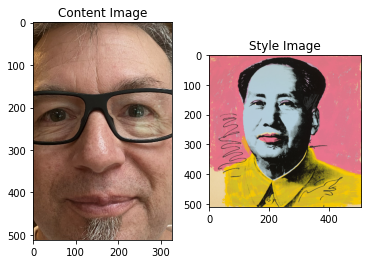

In [25]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

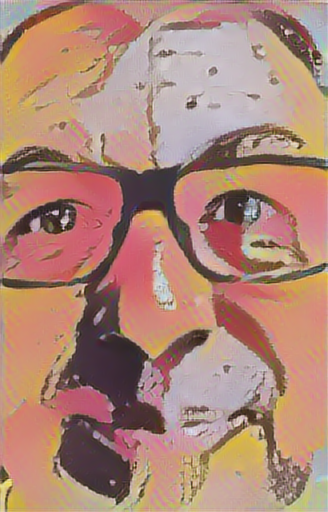

In [26]:
import tensorflow_hub as hub
import os

hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
save_dir = '../data/style_transfers/'
pil_image = tensor_to_image(stylized_image)
pil_image.save(save_dir + '/{}.jpg'.format(len(os.listdir(save_dir))))
pil_image

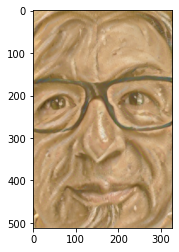

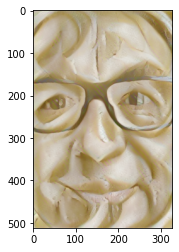

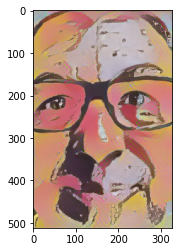

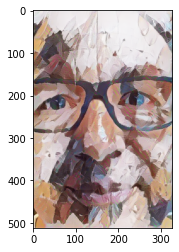

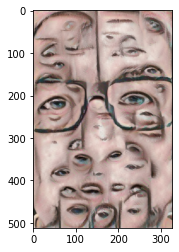

In [33]:
def style_image(content_path, style_path):
  content_image = load_img(content_path)
  style_image = load_img(style_path)
  stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
  save_dir = './style_transfers/'
  pil_image = tensor_to_image(stylized_image)
  # pil_image.save(save_dir + '/{}.jpg'.format(len(os.listdir(save_dir))))
  return pil_image

content_dir = '/Users/carlschader/programming/ml-tensorflow/data/content-images/'
style_dir = '/Users/carlschader/programming/ml-tensorflow/data/styles/'

styles = ['pbj.jpg', 'cream.jpg', 'Andy-Warhol-Mao.jpg', 'streaks.jpg', 'faces.jpg']
content = ['IMG_7568.jpg']

for content_file in content:
  content_path = os.path.join(content_dir, content_file)
  for style_file in styles:
    style_path = os.path.join(style_dir, style_file)
    style_im = load_img(style_path)
    im = style_image(content_path, style_path)
    im.save(save_dir + '/{}.jpg'.format(len(os.listdir(save_dir))))
    # plt.subplot(1, 2, 1)
    # imshow(im, 'Content Image')
    # plt.subplot(1, 2, 2)
    # imshow(style_im, 'Style Image')
    plt.imshow(np.asarray(im))
    plt.show()

In [171]:
x = tf.keras.applications.xception.preprocess_input(content_image*255)
x = tf.image.resize(x, (299, 299))
vgg = tf.keras.applications.Xception(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [172]:
predicted_top_5 = tf.keras.applications.xception.decode_predictions(prediction_probabilities.numpy())[0]
print([(class_name, prob) for (number, class_name, prob) in predicted_top_5])

[('ski_mask', 0.09205984), ('wool', 0.035696685), ('military_uniform', 0.029246472), ('ballplayer', 0.02580076), ('bathing_cap', 0.017931802)]


In [173]:
vgg = tf.keras.applications.Xception(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_21
block1_conv1
block1_conv1_bn
block1_conv1_act
block1_conv2
block1_conv2_bn
block1_conv2_act
block2_sepconv1
block2_sepconv1_bn
block2_sepconv2_act
block2_sepconv2
block2_sepconv2_bn
conv2d_12
block2_pool
batch_normalization_12
add_36
block3_sepconv1_act
block3_sepconv1
block3_sepconv1_bn
block3_sepconv2_act
block3_sepconv2
block3_sepconv2_bn
conv2d_13
block3_pool
batch_normalization_13
add_37
block4_sepconv1_act
block4_sepconv1
block4_sepconv1_bn
block4_sepconv2_act
block4_sepconv2
block4_sepconv2_bn
conv2d_14
block4_pool
batch_normalization_14
add_38
block5_sepconv1_act
block5_sepconv1
block5_sepconv1_bn
block5_sepconv2_act
block5_sepconv2
block5_sepconv2_bn
block5_sepconv3_act
block5_sepconv3
block5_sepconv3_bn
add_39
block6_sepconv1_act
block6_sepconv1
block6_sepconv1_bn
block6_sepconv2_act
block6_sepconv2
block6_sepconv2_bn
block6_sepconv3_act
block6_sepconv3
block6_sepconv3_bn
add_40
block7_sepconv1_act
block7_sepconv1
block7_sepconv1_bn
block7_sepconv2_act
block7_sepcon

In [197]:
content_layers = ['block14_sepconv2_act'] 

style_layers = ['block{}_sepconv2'.format(i) for i in range(11, 13 + 1)]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)
print(num_content_layers, num_style_layers)

1 3


In [198]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.Xception(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [199]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block11_sepconv2
  shape:  (1, 21, 32, 728)
  min:  -161.68509
  max:  146.83218
  mean:  -26.330017

block12_sepconv2
  shape:  (1, 21, 32, 728)
  min:  -143.9005
  max:  110.88593
  mean:  -17.694675

block13_sepconv2
  shape:  (1, 21, 32, 1024)
  min:  -273.96527
  max:  212.42308
  mean:  -9.187084



In [200]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [201]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [202]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block11_sepconv2
    shape:  (1, 728, 728)
    min:  -1570.2264
    max:  2268.4116
    mean:  233.42969

   block12_sepconv2
    shape:  (1, 728, 728)
    min:  -1072.2161
    max:  1814.5005
    mean:  179.41586

   block13_sepconv2
    shape:  (1, 1024, 1024)
    min:  -1884.4745
    max:  2370.7112
    mean:  23.615648

Contents:
   block14_sepconv2_act
    shape:  (1, 16, 13, 2048)
    min:  0.0
    max:  145.0238
    mean:  0.3664742


In [203]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

style_weight=1e-2
content_weight=1e4

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

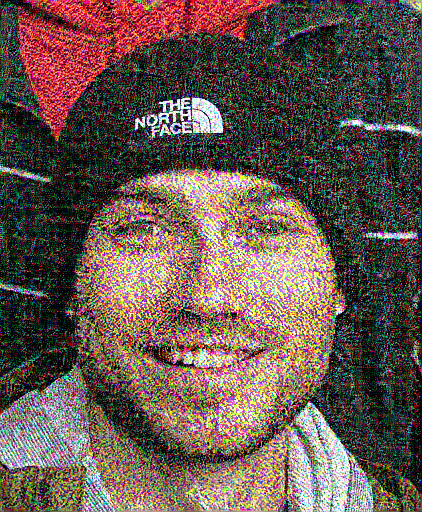

In [204]:
image = tf.Variable(content_image)

for _ in range(100):
  train_step(image)
tensor_to_image(image)